In [27]:
import numpy as np
import theano, theano.tensor as T
import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
def hamilton_mcmc(pi, q, epsilon, L, q_0, n_samples):
    """
    Sample from a target distribution proportional to pi with HMC.
    """
    res = np.empty((n_samples, q_0.shape[0]))
    
    # determine the derivative + functionalise
    U = theano.function([q], -T.log(pi))
    grad_U = theano.function([q], -T.grad(T.log(pi), q))
    
    cur_q = q = q_0
    for i in xrange(n_samples):
        p = np.random.normal(size=q.shape[0])
        cur_p = p
        # half step
        p -= epsilon * grad_U(q) / 2.
        
        # alternate full steps for position and momentum
        for j in xrange(L):
            q += epsilon * p
            if i != L:
                p -= epsilon * grad_U(q)
        
        # now half-step
        p -= epsilon * grad_U(q) / 2.
        
        # negate momentum to make the proposal symmetric
        p = -p
        
        # evaluate potential and kinetic energies at start and end of trajectory
        cur_U = U(cur_q)
        cur_K = np.sum(cur_p**2) / 2.
        new_U = U(q)
        new_K = np.sum(p**2) / 2.
        
        # accept / reject step
        alpha = min(1, np.exp(-new_U + cur_U - new_K + cur_K))
        if np.random.uniform() < alpha:
            res[i,:] = q
            cur_q = q
        else:
            res[i,:] = cur_q
    return res

In [108]:
x = T.dvector('x')
Sigma = np.array([[1,2], [0,1]])
Sigma_inv = np.linalg.inv(Sigma.T.dot(Sigma))
pi = T.exp(-x.dot(Sigma_inv).dot(x))
samp = hamilton_mcmc(pi, x, 0.1, 20, np.array([0., 0.]), 1000)

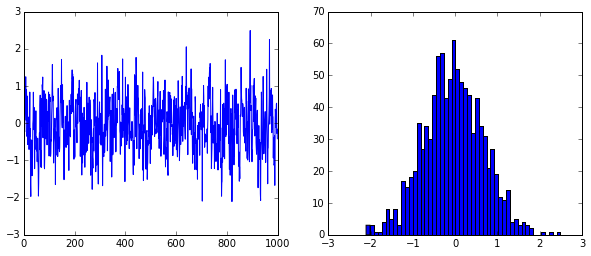

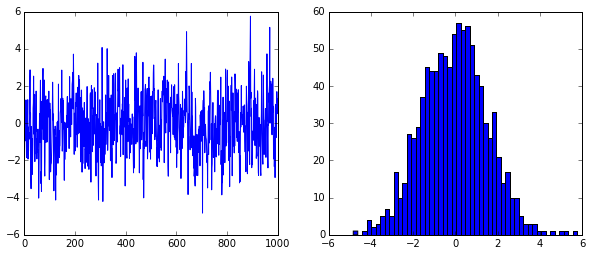

In [109]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(samp[:,0]);
plt.subplot(122)
plt.hist(samp[:,0], 50)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(samp[:,1])
plt.subplot(122)
plt.hist(samp[:,1], 50);

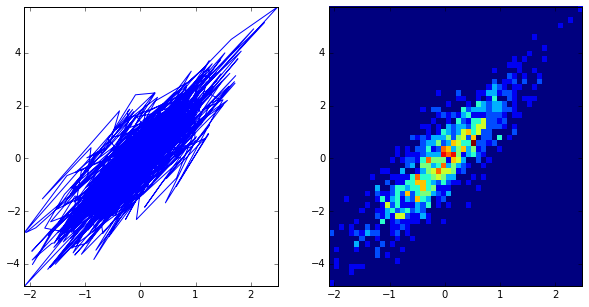

In [110]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.plot(samp[:,0], samp[:,1])
ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
plt.hist2d(samp[:,0], samp[:,1], 50);